# On Parcels
> An introductory article to Cryptovoxels' Parcel Data

- toc: true
- title: Parcels
- template: article
- description: this isnt working
- image: images/company_logo.png
- keywords: thisworks
- badges: true
- comments: true
- categories: [test]
- hide: false
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

I love freebies. In my opinion, guestbooks are the ticket to a bunch of em!

So what's the best way to find em all?

Perhaps the same way to find out a lot of really cool information... 🤔

## Parcel Data

In [ ]:
#hide 
!pip install matplotlib
!pip install geopandas
!pip install folium

For starters CV provides generic data on ALL their [parcels](https://www.cryptovoxels.com/api/parcels/search.json)

In [1]:
#hide 
import requests
import json
url = 'https://www.cryptovoxels.com/api/parcels/search.json'
r = requests.get(url)
data = json.loads(r.text)['parcels'] 

In [6]:
#hide 
import pandas as pd
import geopandas as gpd
gdf = { "type": "FeatureCollection", "features": [] }
for obj in data:
  feat = { "type": "Feature", "geometry": { "type": "Polygon", "coordinates": [ ] }, "properties": { } }
  feat['geometry']['coordinates'] = obj['geometry']['coordinates'] 
  feat['properties'] = {key: obj[key] for key in obj if key not in ['x1','x2','y1','y2','z1','z2','geometry']}
  gdf['features'].append(feat)  

# What fresh hell have I done here?
with open('../data/cv.geojson', 'w') as outfile: json.dump(gdf, outfile)

gdf = gpd.read_file('../data/cv.geojson')
gdf['id'] = gdf.id.astype(str) 
gdf['vol'] = gdf['area'] * gdf['height'] 
gdf.to_file("../data/cv.geojson", driver='GeoJSON')

In [3]:
import folium
import branca
import branca.colormap as cm
from branca.colormap import linear

In [9]:
# https://stackoverflow.com/questions/54595931/show-different-pop-ups-for-different-polygons-in-a-geojson-folium-python-ma
# https://python-visualization.github.io/branca/colormap.html

mymap = folium.Map(location=[0,0], tiles = 'https://map.cryptovoxels.com/tile?z={z}&x={x}&y={y}', attr="Map data &copy; Cryptovoxels", zoom_start=10, control_scale=True)
colormap = cm.LinearColormap(colors=['white', 'blue','green', 'yellow', 'orange', 'red'], caption="Parcel Volume").to_step(data=gdf['vol'], method='quant', quantiles=[0,0.25,0.5,0.75,0.98, 0.999, 0.9999,1])
style_function = lambda x: {"weight":0.5, 'color':'black', 'fillColor':colormap(x['properties']['vol']), 'fillOpacity':0.75}
highlight_function = lambda x: {'fillColor': '#000000', 'color':'#000000', 'fillOpacity': 0.50, 'weight': 0.1}

layer = folium.FeatureGroup(name='your layer name', show=False)
temp_geojson = folium.GeoJson(gdf)
for feature in temp_geojson.data['features']:  
    innerHTML = '<b>'+str(feature['properties']['island'])+' - '+str(feature['properties']['suburb']) + '</b><br>'
    innerHTML += '<b> Address - ' +str(feature['properties']['address']) + '</b><br>'
    innerHTML += '<b> Height - ' +str(feature['properties']['height']) + '</b><br>'
    innerHTML += '<b> Area - ' +str(feature['properties']['area']) + '</b><br>'
    innerHTML += '<b> Volume - ' +str(feature['properties']['vol']) + '</b><br>'
    temp_layer = folium.GeoJson(feature, style_function=style_function, highlight_function=highlight_function, tooltip=innerHTML) 
    foo = lambda txt, source: f""" <a id="popupIFrame" width="600" height="600" align="center" href="{source}"> Visit </a><br>{txt}"""
    folium.Popup( html=foo(innerHTML, f'https://www.cryptovoxels.com/parcels/{feature["properties"]["id"]}') ).add_to(temp_layer)
    temp_layer.add_to(layer)

layer.add_to(mymap)
colormap.add_to(mymap) 
mymap.save('../docs/maps/cv_vol_map.html')

In [6]:
#hide 
# df = gdf[gdf['island'] == 'Scarcity'] # Only Scarcity Island 
# gdf[gdf['island']=='Scarcity']['island'].describe()
# gdf[gdf['island']=='Scarcity'].plot()

The data contains geocoordinates and a bit of meta data which can let us do fun stuff like this <a href="https://cvminigames.com/blog/docs/maps/cv_vol_map.html"> map </a>.

Where: 
- Color depicts volume broke out by quartile.

- And the top largest 2% and 1% of parcels painted orange and red, respectively.

In [16]:
%%html
<iframe height='500px' width='1000px' src="https://cvminigames.com/blog/docs/maps/cv_vol_map.html"/>

We can do other things like some light analysis. 

Here is a frequency plot of Flora Islands Volume (excluding it's outlier)

<AxesSubplot:ylabel='Frequency'>

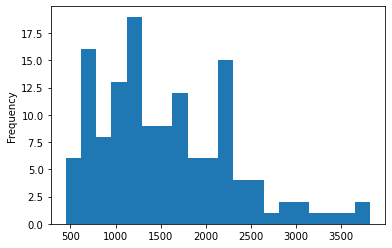

In [26]:
#hide_input 
t = gdf[gdf['island']=='Flora']
q_low = t["vol"].quantile(0.01)
q_hi  = t["vol"].quantile(0.99)
t = t[(t["vol"] < q_hi) & (t["vol"] > q_low)]
t['vol'].plot.hist(bins=20)

Ok. So thats nice...

I'll do more exploration on this end some time later...

What else can we do?

## Filtering Parcels

Information about a specific parcel is available by adding it's parcel # to the end of the following url: https://www.cryptovoxels.com/api/parcels/  

This data can then be filtered en-mass to search for certain properties, or inspected individually.

In [ ]:
#hide
# This code will save each parcel featurelist

import requests
import json
t = """
deets = []
for index, row in df.tail(200).iterrows():
  url = 'https://www.cryptovoxels.com/api/parcels/'+str(row['id'])+'.json' 
  r = requests.get(url)
  data = json.loads(r.text) 
  with open('./parcels/'+str(row['id'])+'.json', 'w') as file:
    json.dump(data, file)
  print(row['id'])
"""

In [ ]:
#hide 
import json
from shapely.geometry import Polygon
pd.options.display.max_colwidth = 500
deets = []
# read in each record
for index, row in gdf.iterrows():
  url = '../data/parcels/'+str(row['id'])+'.json'
  data = ''
  # Check for a guestbook
  with open(url, 'r') as j: data = json.loads(j.read())['parcel']  
  if data['content']  == None: continue 
  if 'features' not in data['content']: continue 
  # SKIPS OVER PARCELS WITH NO FEATURES

  newobj = {key: data[key] for key in data if key not in ['x1','x2','y1','y2','z1','z2','token','visible','geometry', 'streets', 'voxels', 'content', 'price', 'is_common']} 
  c = data['geometry']['coordinates'][0];
  newobj['geometry'] = Polygon( [[c[0][0], c[0][1]], [c[1][0], c[1][1]], [c[2][0], c[2][1]], [c[3][0], c[3][1]] ] )

  # Multiply centroid's x and y by 100
  centroid = newobj['geometry'].centroid   
  x = centroid.x * 100; x = str(x)[:5]+'E'; x = x.replace('.', '');
  y = centroid.y * 100; y = str(y)[:5]+'N'; y = y.replace('.', '');
  substractBy = -4.7 if (newobj['island'] == 'Scarcity') else -1.5
  newobj['link'] = 'https://www.cryptovoxels.com/play?coords=W@'+str(x)+','+str(y)+',30F'

  # Books
  guestbook = list(filter(lambda x: x['type'] == 'guest-book', data['content']['features'])) 
  if guestbook:  
    position = guestbook[0]['position']
    newobj['book-position'] = guestbook[0]['position']

  deets.append( newobj )

test = pd.json_normalize(data=deets)
testgdf = gpd.GeoDataFrame(test, geometry='geometry', crs='epsg:3857')

For example we can search for parcels with guest-books!

In [ ]:
testgdf['label'].unique()

array([None, 'club', 'library', 'gallery', 'shops', 'education',
       'sandbox', 'park', 'teleports', 'music', 'scenic', 'beach', 'bar',
       '', 'concert', 'game', 'money', 'rest', 'sports', 'theater',
       'food', 'animal', 'factory'], dtype=object)

In [ ]:
#hide_input 
testgdf.head(5)

In [ ]:
#hide_input 
testgdf[ ( testgdf['book-position'].notnull() ) ].drop(columns=['geometry'])[['link','book-position']].head(5)

And display it on a map

In [ ]:
#hide_input 
# .head().map(lambda z: z)
import numpy as np
testgdf['color'] = np.where( testgdf['book-position'].notnull(),1, 2)
# testgdf[ ( testgdf['island'] == 'Scarcity' ) & ( testgdf['book-position'].notnull() ) ].plot(column='color')
testgdf[ ( testgdf['island'] == 'Scarcity' ) ].plot(column='color')

An interactive one.

In [ ]:
#hide 
fingdf = testgdf.copy()

In [ ]:
fingdf['id'] = fingdf.index.astype(str) 
fingdf['vol'] = fingdf['area'] * fingdf['height'] 

In [ ]:
fingdf['bounds'] = tuple(  fingdf['geometry'].bounds[x:x + 2]
   for x in range(0, len( fingdf['geometry'].bounds), 2) 
)